In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Preprocess Customers data
customers['SignupDate'] = pd.to_datetime(customers['SignupDate']).dt.year
le = LabelEncoder()
customers['Region'] = le.fit_transform(customers['Region'])

# Aggregate transactions by customer
transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()

# Merge datasets
data = pd.merge(customers, transaction_summary, on='CustomerID', how='inner')

# Normalize features
scaler = StandardScaler()
features = ['SignupDate', 'Region', 'TotalValue', 'Quantity']
data_scaled = scaler.fit_transform(data[features])


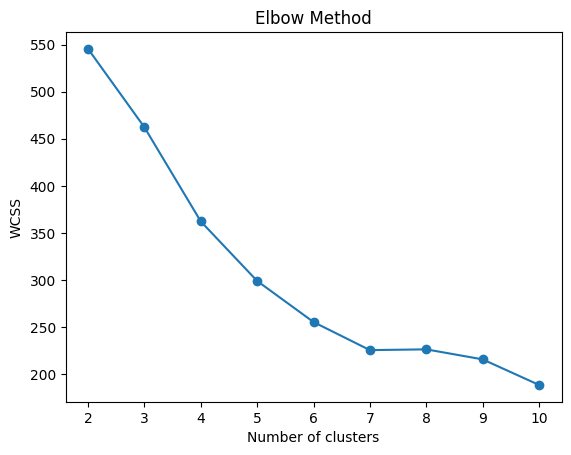

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Determine optimal clusters using Elbow Method
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
import matplotlib.pyplot as plt
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Fit KMeans with optimal clusters
kmeans = KMeans(n_clusters=4, random_state=42)  # Replace 4 with the optimal number from Elbow
clusters = kmeans.fit_predict(data_scaled)
data['Cluster'] = clusters


In [5]:
db_index = davies_bouldin_score(data_scaled, clusters)
sil_score = silhouette_score(data_scaled, clusters)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {sil_score}")


Davies-Bouldin Index: 1.1238106344819085
Silhouette Score: 0.2628490431407157


KMeans - Davies-Bouldin Index: 0.8650620583623065


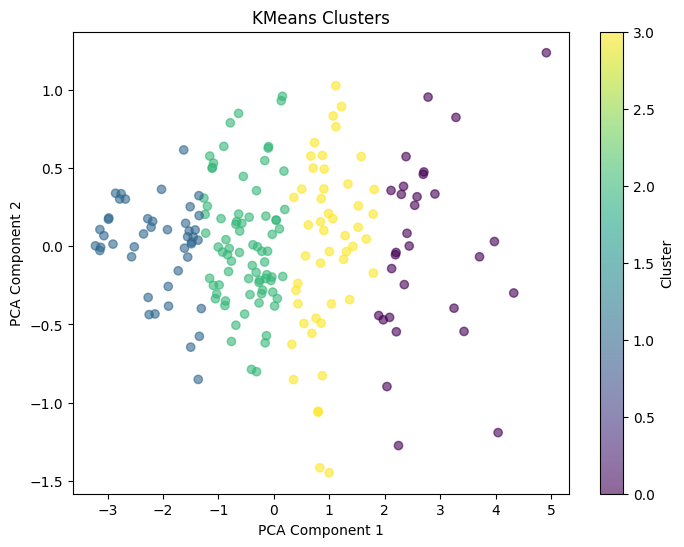

Agglomerative Clustering - Davies-Bouldin Index: 0.807675078528194


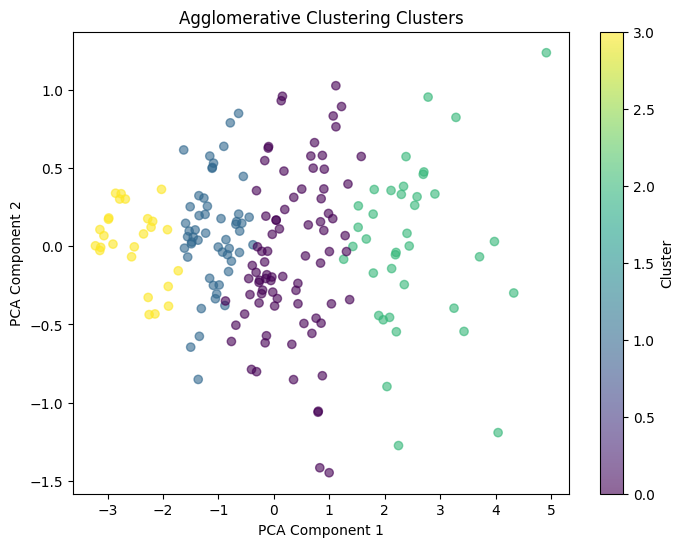

DBSCAN Clustering - Davies-Bouldin Index: 0.2813229606570524


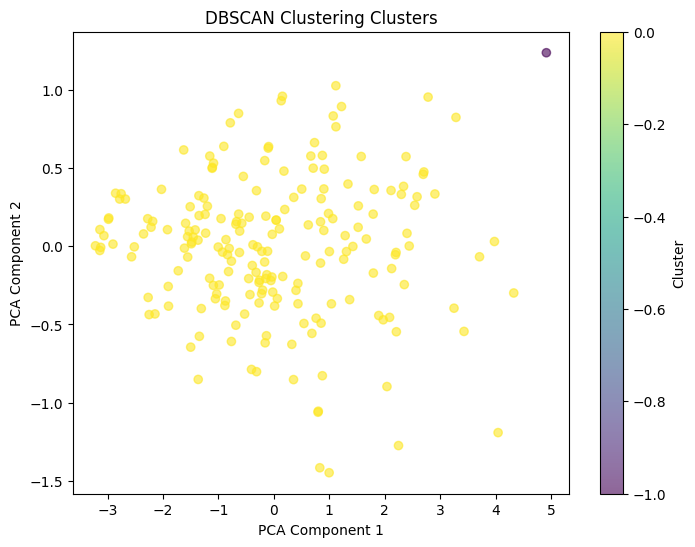


Clustering Evaluation Summary:
KMeans DB Index: 0.8650620583623065
Agglomerative Clustering DB Index: 0.807675078528194
DBSCAN DB Index: 0.2813229606570524

KMeans Cluster Summary:
                 TotalValue              Quantity      TransactionID       \
                       mean        sum       mean  sum          mean  sum   
KMeans_Cluster                                                              
0               6263.447333  187903.42  23.000000  690      8.433333  253   
1               1273.368182   56028.20   5.272727  232      2.363636  104   
2               2982.406711  226662.91  10.868421  826      4.394737  334   
3               4477.572041  219401.03  16.102041  789      6.306122  309   

               CustomerID  
                    count  
KMeans_Cluster             
0                      30  
1                      44  
2                      76  
3                      49  

Agglomerative Clustering Summary:
                        TotalValue             

In [8]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# Function to evaluate clustering and plot results
def evaluate_and_plot(data_scaled, labels, title):
    db_index = davies_bouldin_score(data_scaled, labels)
    print(f"{title} - Davies-Bouldin Index: {db_index}")

    # PCA for visualization
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap="viridis", alpha=0.6)
    plt.title(f"{title} Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label="Cluster")
    plt.show()

    return db_index

# Load and preprocess data (repeated from earlier)
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

customer_transactions = transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",
    "TransactionID": "count"
}).reset_index()

data = pd.merge(customers, customer_transactions, on="CustomerID")
features = ["TotalValue", "Quantity", "TransactionID"]
data_features = data[features]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_features)

# 1. KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
data["KMeans_Cluster"] = kmeans.fit_predict(data_scaled)
kmeans_db_index = evaluate_and_plot(data_scaled, data["KMeans_Cluster"], "KMeans")

# 2. Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=4)
data["Agglomerative_Cluster"] = agg_clustering.fit_predict(data_scaled)
agg_db_index = evaluate_and_plot(data_scaled, data["Agglomerative_Cluster"], "Agglomerative Clustering")

# 3. DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Adjust parameters as needed
data["DBSCAN_Cluster"] = dbscan.fit_predict(data_scaled)
dbscan_db_index = evaluate_and_plot(data_scaled, data["DBSCAN_Cluster"], "DBSCAN Clustering")

# Summary of DB Index values
print("\nClustering Evaluation Summary:")
print(f"KMeans DB Index: {kmeans_db_index}")
print(f"Agglomerative Clustering DB Index: {agg_db_index}")
print(f"DBSCAN DB Index: {dbscan_db_index}")

# Cluster Analysis for KMeans
kmeans_cluster_summary = data.groupby("KMeans_Cluster").agg({
    "TotalValue": ["mean", "sum"],
    "Quantity": ["mean", "sum"],
    "TransactionID": ["mean", "sum"],
    "CustomerID": "count"
})
print("\nKMeans Cluster Summary:")
print(kmeans_cluster_summary)

# Cluster Analysis for Agglomerative Clustering
agg_cluster_summary = data.groupby("Agglomerative_Cluster").agg({
    "TotalValue": ["mean", "sum"],
    "Quantity": ["mean", "sum"],
    "TransactionID": ["mean", "sum"],
    "CustomerID": "count"
})
print("\nAgglomerative Clustering Summary:")
print(agg_cluster_summary)

# Cluster Analysis for DBSCAN
dbscan_cluster_summary = data.groupby("DBSCAN_Cluster").agg({
    "TotalValue": ["mean", "sum"],
    "Quantity": ["mean", "sum"],
    "TransactionID": ["mean", "sum"],
    "CustomerID": "count"
})
print("\nDBSCAN Cluster Summary:")
print(dbscan_cluster_summary)
